In [1]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import math
from tqdm import tnrange, tqdm_notebook
from time import sleep, time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#%matplotlib inline

warnings.filterwarnings('ignore')
HOLDOUT = 10
n_experimento = 1
experimento_folder = 'Experimento'+str(n_experimento)

r = 0.01
os.chdir("C:\\Users\\EMANUEL\\Desktop\\Autofaces Modificado\\FPCA_Genetico")
os.getcwd()

'C:\\Users\\EMANUEL\\Desktop\\Autofaces Modificado\\FPCA_Genetico'

In [2]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    #print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    #print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [3]:
print(CarregarYaleFaces()[0].shape)

(165, 644)


In [4]:
def F_Eigenfaces(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, r) - np.power(mean,r)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X,r) - np.power(mean,r)).T)
    X__ = vec_c.T.dot((np.power(W,r) - np.power(mean,r)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [5]:
def F_Eigenfaces2(X, W, k, R):
    r = 0.01
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, R) - np.power(mean, R)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X, R) - np.power(mean, R)).T)
    X__ = vec_c.T.dot((np.power(W, R) - np.power(mean, R)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [6]:
def generate_R2(r, LINHAS, COLUNAS):
    #M_ = np.random.rand(4)
    width = 23
    height = 28
    r = np.array(r).reshape((LINHAS,COLUNAS))
    
    h = height // LINHAS
    w = width // COLUNAS
    
    h_ = height % LINHAS
    w_ = width % COLUNAS
    
    R = []
    for i in range(LINHAS):
        R_ = []
        for j in range(COLUNAS):
            if(j != COLUNAS-1):
                R_.extend(w * [r[i][j]])
            else:
                R_.extend((w + w_) * [r[i][j]])
        if(i != LINHAS-1):
            R_ *= h
        else:
            R_ *= (h + h_)
        R.extend(R_)
        
    return R

In [47]:
def AvaliarClassificadores2(X_train, X_test, y_train, y_test):
    
    clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    return clf_1nn.score(X_test, y_test) * 100

In [74]:
def ExperimentoSimples(X, Y, i, K, filename):
    #LINHA TEMPORARIA
    #R = ler(filename)
    R = filename
    n_componentes = K
    
    #for i in tqdm(range(1, 16)):
    s_feig = []
    s_feig_star = []


    for j in range(HOLDOUT):
    #for j in tqdm_notebook(range(HOLDOUT), desc='Nº c:{0}'.format(n_componentes)):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state= round(time()) + 15 * j)
        #print(X_train)

        #gerar os conjuntos de treino e teste transformados
        #X_pca_train, X_pca_test  = PCA(X_train, X_test, n_componentes)
        l = int(np.sqrt(len(R[0])))
        X_feig_train, X_feig_test = F_Eigenfaces(X_train, X_test, n_componentes, r)
        X_feig_star_train, X_feig_star_test = F_Eigenfaces2(X_train, 
                                                            X_test, 
                                                            n_componentes, 
                                                            generate_R2(R[i], l, l))

        #acuracias
        #s_pca.append(AvaliarClassificadores2(X_pca_train, X_pca_test, y_train, y_test))X_eige_test
        s_feig.append(AvaliarClassificadores2(X_feig_train, X_feig_test, y_train, y_test))
        s_feig_star.append(AvaliarClassificadores2(X_feig_star_train, X_feig_star_test, y_train, y_test))

    print('Finalizado')
    return np.array(s_feig).mean(), np.array(s_feig_star).mean()
    

In [132]:
def Experimento(X, Y, filename):
    acc = []
    std = []
    
    #LINHA TEMPORARIA
    #R = ler(filename)
    R = filename
    n_componentes = 1
    
    #for i in tqdm(range(1, 16)):
    for i in tnrange(15, desc='Progresso '):
        
        #print('N Components : %s' %(str(n_componentes)))
            
        #print('# Progresso :'+str(n_componentes)+'/70')
        
        #s_pca = []
        
        s_feig = []
        s_feig_star = []
        
        
        #for j in range(HOLDOUT):
        for j in tqdm_notebook(range(HOLDOUT), desc='Nº c:{0}'.format(n_componentes)):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state= round(time()) + 15 * j)
            #print(X_train)

            #gerar os conjuntos de treino e teste transformados
            #X_pca_train, X_pca_test  = PCA(X_train, X_test, n_componentes)
            l = int(np.sqrt(len(R[0])))
            X_feig_train, X_feig_test = F_Eigenfaces(X_train, X_test, n_componentes, r)
            X_feig_star_train, X_feig_star_test = F_Eigenfaces2(X_train, 
                                                                X_test, 
                                                                n_componentes, 
                                                                generate_R2(R[i], l, l))
            
            #acuracias
            #s_pca.append(AvaliarClassificadores2(X_pca_train, X_pca_test, y_train, y_test))X_eige_test
            s_feig.append(AvaliarClassificadores2(X_feig_train, X_feig_test, y_train, y_test))
            s_feig_star.append(AvaliarClassificadores2(X_feig_star_train, X_feig_star_test, y_train, y_test))

        #print(s_fpca)
        acc.append([#np.array(s_pca).mean(),
                    np.array(s_feig).mean(),
                    np.array(s_feig_star).mean()])
        
        std.append([#np.std(s_pca),
                    np.std(s_feig) / 100,
                    np.std(s_feig_star) / 100])
        
        if(n_componentes == 1):
            n_componentes += 4
        else:
            n_componentes += 5
            
            sleep(0.01)
        
    return np.array(acc), np.array(std)

In [75]:
def ImprimirResultados(acc, dataset_name):
    
    x = np.arange(0, 15)
    x = x * 5
    x[0] += 1
    #print(len(x))
    #plt.figure(figsize=(20,15))
    plt.title("Dataset: "+dataset_name+" - Classificador: 1-NN")
    #plt.plot(x, acc_yale[:,0], color='black')
    plt.plot(x, acc[:,0], color='red')
    plt.plot(x, acc[:,1], color='blue')
    plt.ylabel('Acuracia media')
    plt.xlabel('Numero de componentes')
    #plt.legend(labels=['PCA','FPCA','Eigenfaces','F Eigenfaces'])
    plt.legend(labels=['F Eigenfaces','F Eigenfaces *'])
    plt.grid()
    #plt.show()

In [151]:
X, Y = CarregarYaleFaces()
acc_yale = [list([0., 0.]) for i in range(15)]
for i,c in enumerate(components):
    x1, x2 = ExperimentoSimples(X, Y, i, c, v2)
    acc_yale[i] = [x1, x2]
acc_yale = np.array(acc_yale)

Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado
Finalizado


In [185]:
import random
def generate_r(size, base, interval):
    r = []
    for i in range(size):
        noise = random.random()
        while(noise > interval):
            noise = random.random()
        r.append(base + noise)
    return r

In [182]:
import random
random.random() / 0.5

1.8289520787622593

In [201]:
generate_r(9, 0.01, 0.02)

[0.026910007161966558,
 0.02661168074322872,
 0.02046937648523805,
 0.01347415790578165,
 0.015148539571042332,
 0.01563025016926,
 0.019992328342485426,
 0.025089594747003778,
 0.013139004237401322]

In [202]:
components = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
v2 = [[0.015, 0.086, 0.0655, 0.014, 0.01, 0.1, 0.025, 0.16, 0.018], #0-1
      [0.029, 0.072, 0.043, 0.0699, 0.023, 0.024, 0.071, 0.024, 0.025], #1-5
      [0.01, 0.09, 0.025, 0.068, 0.01, 0.05, 0.08, 0.1, 0.025], #2-10
      [0.0432, 0.08798, 0.0145, 0.0625, 0.0412, 0.066, 0.077, 0.025, 0.040], #3-15
      [0.012022218992665637,
 0.01489475007016238,
 0.011930171386344104,
 0.010391943091747615,
 0.013890086419421568,
 0.011290831560481376,
 0.014538144824352109,
 0.014905381619860427,
 0.013854921580617066], #4-20
      [0.012561054913532424,
 0.014644324133868727,
 0.013562335599403555,
 0.01264146345001226,
 0.0105824732572699,
 0.011767659040871728,
 0.014557037897807481,
 0.010067285965368091,
 0.016566888886402446], #5-25
      [0.026910007161966558,
 0.02661168074322872,
 0.02046937648523805,
 0.01347415790578165,
 0.015148539571042332,
 0.01563025016926,
 0.019992328342485426,
 0.025089594747003778,
 0.013139004237401322], #6-30
      [0.013, 0.065, 0.077, 0.068, 0.027, 0.029, 0.023, 0.055, 0.074], #7-35
      [0.029, 0.072, 0.043, 0.0699, 0.023, 0.024, 0.071, 0.024, 0.025], #8-40
      [0.029, 0.072, 0.043, 0.0699, 0.023, 0.024, 0.071, 0.024, 0.025], #9-45
      [0.029, 0.072, 0.043, 0.0699, 0.023, 0.024, 0.071, 0.024, 0.025], #10-50
      [0.013, 0.065, 0.077, 0.068, 0.027, 0.029, 0.023, 0.055, 0.074], #11-55
      [0.0432, 0.08798, 0.0145, 0.0625, 0.0412, 0.066, 0.077, 0.025, 0.040], #12-60
      [0.013, 0.065, 0.077, 0.068, 0.027, 0.029, 0.023, 0.055, 0.074], #13-65
      [0.0432, 0.08798, 0.0145, 0.0625, 0.0412, 0.066, 0.077, 0.025, 0.040]] #14-70

In [203]:
K = 6
x1, x2 = ExperimentoSimples(X, Y, K, components[5], v2)
acc_yale[K] = [x1, x2]
acc_yale = np.array(acc_yale)

Finalizado


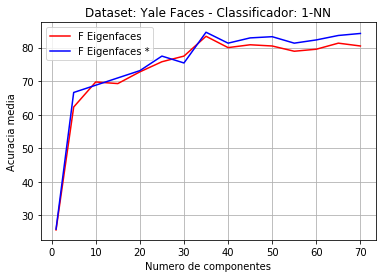

In [204]:
ImprimirResultados(acc_yale, "Yale Faces")

In [237]:
#calculando as acuracias (70 x 4)
print("---Yale---")
#acc_yale, std_yale = Experimento(X, Y, experimento_folder+'\\genetico\\genetico_yale.txt')
acc_yale, std_yale = Experimento(X, Y, v2)

---Yale---


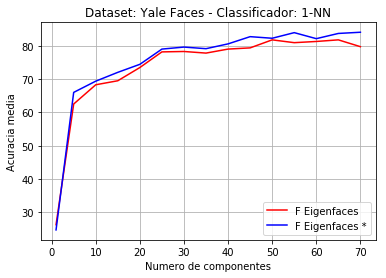

In [238]:
ImprimirResultados(acc_yale, "Yale Faces")

In [239]:
#salvando as acuracias dos classificadores
acc = acc_yale
n_experimento = 3
experimento_folder = 'Experimento'+str(n_experimento)
folder = 'acc'
dataset = 'yale'

filename1 = experimento_folder+'\\'+folder+'\\acc_'+dataset+'_eigenfaces.csv'
filename2 = experimento_folder+'\\'+folder+'\\acc_'+dataset+'_eigenfaces_proposed.csv'
np.savetxt(filename1, acc[:,0], delimiter=',')
np.savetxt(filename2, acc[:,1], delimiter=',')